### Installing packages

- keras - deep learning
- scikit-learn - general purpose machine learning
- imbalanced-learn - methods that address class imbalance problem

In [1]:
!pip install keras scikit-learn imbalanced-learn

### Imports that we'll use along the way

- numpy - linear algebra
- keras - deep learning
- sklearn.dataset - to download Labeled Faces in the Wild dataset
- sklearn.model_selection - for dataset train/test split
- sklearn.metrics - to measure the performance of our classifier
- matplotlib.pyplot - showing images and plots
- imblearn.over_sampling - random oversampling method to handle class imalance

In [2]:
import numpy as np
import keras
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler

### Labeled Faces in the Wild dataset

The cell below downloads the dataset using `fetch_lfw_people` function and checks the dimensionality of the datset.

There are some parameters that control e.g. the minimum number of images per class (person), image size, etc.

Here is a link to the function's documentation: [fetch_lfw_people](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html).

In [3]:
lfw_people = fetch_lfw_people(min_faces_per_person=20, color=True, resize=1.0, slice_=(slice(48, 202), slice(48, 202)))

X = lfw_people.images
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print('number of examples: {}'.format(y.shape[0]))
print('dimensionality of images: {}'.format(X.shape[1:]))
print('number of unique classes (people): {}'.format(n_classes))

number of examples: 3023
dimensionality of images: (154, 154, 3)
number of unique classes (people): 62


**Printing names of 62 classes / Celebrities**


In [4]:
print (target_names)

['Alejandro Toledo' 'Alvaro Uribe' 'Amelie Mauresmo' 'Andre Agassi'
 'Angelina Jolie' 'Ariel Sharon' 'Arnold Schwarzenegger'
 'Atal Bihari Vajpayee' 'Bill Clinton' 'Carlos Menem' 'Colin Powell'
 'David Beckham' 'Donald Rumsfeld' 'George Robertson' 'George W Bush'
 'Gerhard Schroeder' 'Gloria Macapagal Arroyo' 'Gray Davis'
 'Guillermo Coria' 'Hamid Karzai' 'Hans Blix' 'Hugo Chavez' 'Igor Ivanov'
 'Jack Straw' 'Jacques Chirac' 'Jean Chretien' 'Jennifer Aniston'
 'Jennifer Capriati' 'Jennifer Lopez' 'Jeremy Greenstock' 'Jiang Zemin'
 'John Ashcroft' 'John Negroponte' 'Jose Maria Aznar'
 'Juan Carlos Ferrero' 'Junichiro Koizumi' 'Kofi Annan' 'Laura Bush'
 'Lindsay Davenport' 'Lleyton Hewitt' 'Luiz Inacio Lula da Silva'
 'Mahmoud Abbas' 'Megawati Sukarnoputri' 'Michael Bloomberg' 'Naomi Watts'
 'Nestor Kirchner' 'Paul Bremer' 'Pete Sampras' 'Recep Tayyip Erdogan'
 'Ricardo Lagos' 'Roh Moo-hyun' 'Rudolph Giuliani' 'Saddam Hussein'
 'Serena Williams' 'Silvio Berlusconi' 'Tiger Woods' 'Tom Das

**Let's plot a histogram showing how many examples per class we have.**

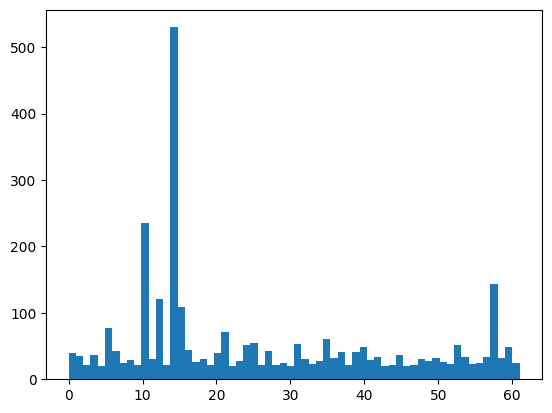

In [5]:
_ = plt.hist(y, bins=n_classes)

**Next, we display a random image along with its label.**

George W Bush


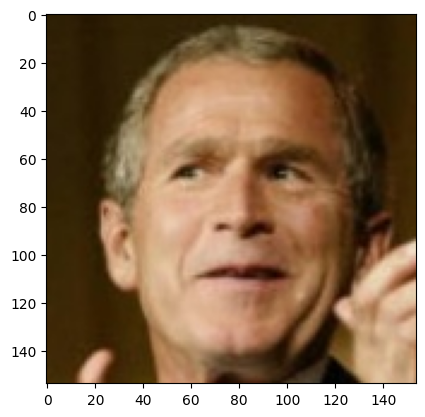

In [67]:
i = np.random.randint(len(lfw_people.images))
plt.imshow(lfw_people.images[i], cmap='gray')
plt.grid(False)
print(target_names[y[i]])

### Deep learning

Let's build a MobileNetV2 Model

First, we need to import some stuff from Keras.

In [21]:
import cv2
from keras.applications import MobileNetV2
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import EarlyStopping
from imblearn.under_sampling import RandomOverSampler
from keras.callbacks import ModelCheckpoint

In [13]:
# Load pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(160, 160, 3))

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(n_classes, activation='softmax')(x)

# Create the transfer learning model
model = Model(inputs=base_model.input, outputs=output)

9406464/9406464 [==============================] - 0s 0us/step


# Plotting the CNN architecture

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][0]']           


**We create a `DataGenerator` object for adding some data augmentation to prevent overfitting.**

In [16]:
# Data preprocessing
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1)

### Training

In [17]:
# Resize images
X_resized = np.array([cv2.resize(img, (160, 160)) for img in X])

In [18]:
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resized, y, test_size=0.2, stratify=y, random_state=42)

In [19]:
# Oversampling each class to contain at least 256 examples
sampling_targets = np.maximum([200] * n_classes, np.bincount(y_train))
ratio_dict = dict(zip(range(n_classes), sampling_targets))
ros = RandomOverSampler(sampling_strategy=ratio_dict, random_state=42)

X_train_shape = X_train.shape
X_train = np.reshape(X_train, (X_train_shape[0], -1))
X_train, y_train = ros.fit_resample(X_train, y_train)
X_train = np.reshape(X_train, (len(X_train),) + X_train_shape[1:])

In [20]:
# Encoding of labels
y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

In [22]:
# Define hyperparameters
batch_size = 256
epochs = 100
base_lr = 0.0001

# Compile model and define optimization
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Nadam(learning_rate=base_lr),
              metrics=['accuracy'])

# Define checkpoints for saving weights
checkpoint_best = ModelCheckpoint('best_weights.h5', monitor='val_loss', save_best_only=True)
checkpoint_every_10 = ModelCheckpoint('weights_epoch_{epoch:02d}.h5', save_freq=10)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Model training
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=datagen.flow(X_test, y_test),
    callbacks=[early_stopping, checkpoint_best, checkpoint_every_10]
)

Epoch 1/100
49/49 [==============================] - 114s 2s/step - loss: 3.9664 - accuracy: 0.0753 - val_loss: 4.2895 - val_accuracy: 0.0215
Epoch 2/100
49/49 [==============================] - 87s 2s/step - loss: 2.7252 - accuracy: 0.3465 - val_loss: 4.1462 - val_accuracy: 0.0479
Epoch 3/100
49/49 [==============================] - 84s 2s/step - loss: 1.4480 - accuracy: 0.6543 - val_loss: 3.9399 - val_accuracy: 0.0678
Epoch 4/100
49/49 [==============================] - 85s 2s/step - loss: 0.7113 - accuracy: 0.8389 - val_loss: 3.6511 - val_accuracy: 0.1339
Epoch 5/100
49/49 [==============================] - 83s 2s/step - loss: 0.3627 - accuracy: 0.9267 - val_loss: 3.5567 - val_accuracy: 0.1455
Epoch 6/100
49/49 [==============================] - 85s 2s/step - loss: 0.2136 - accuracy: 0.9605 - val_loss: 3.3902 - val_accuracy: 0.1769
Epoch 7/100
49/49 [==============================] - 84s 2s/step - loss: 0.1320 - accuracy: 0.9761 - val_loss: 3.1833 - val_accuracy: 0.2529
Epoch 8/100


In [23]:
model.save('weights.h5')

### Results

**Let's plot the training history to assess model's accuracy and loss.**


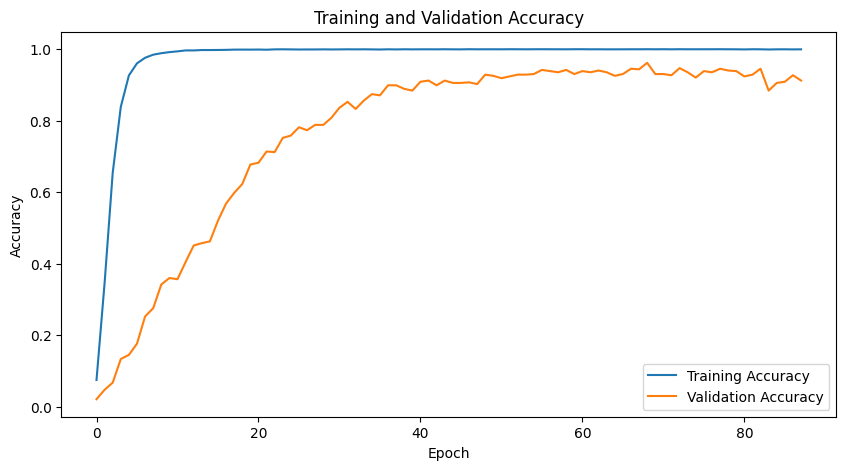

In [84]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

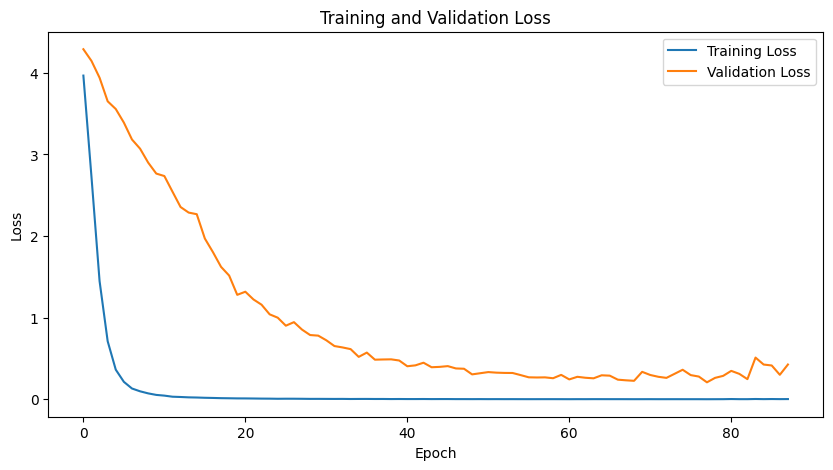

In [85]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

**Visualize the test results using confusion matrix.**

19/19 [==============================] - 0s 24ms/step


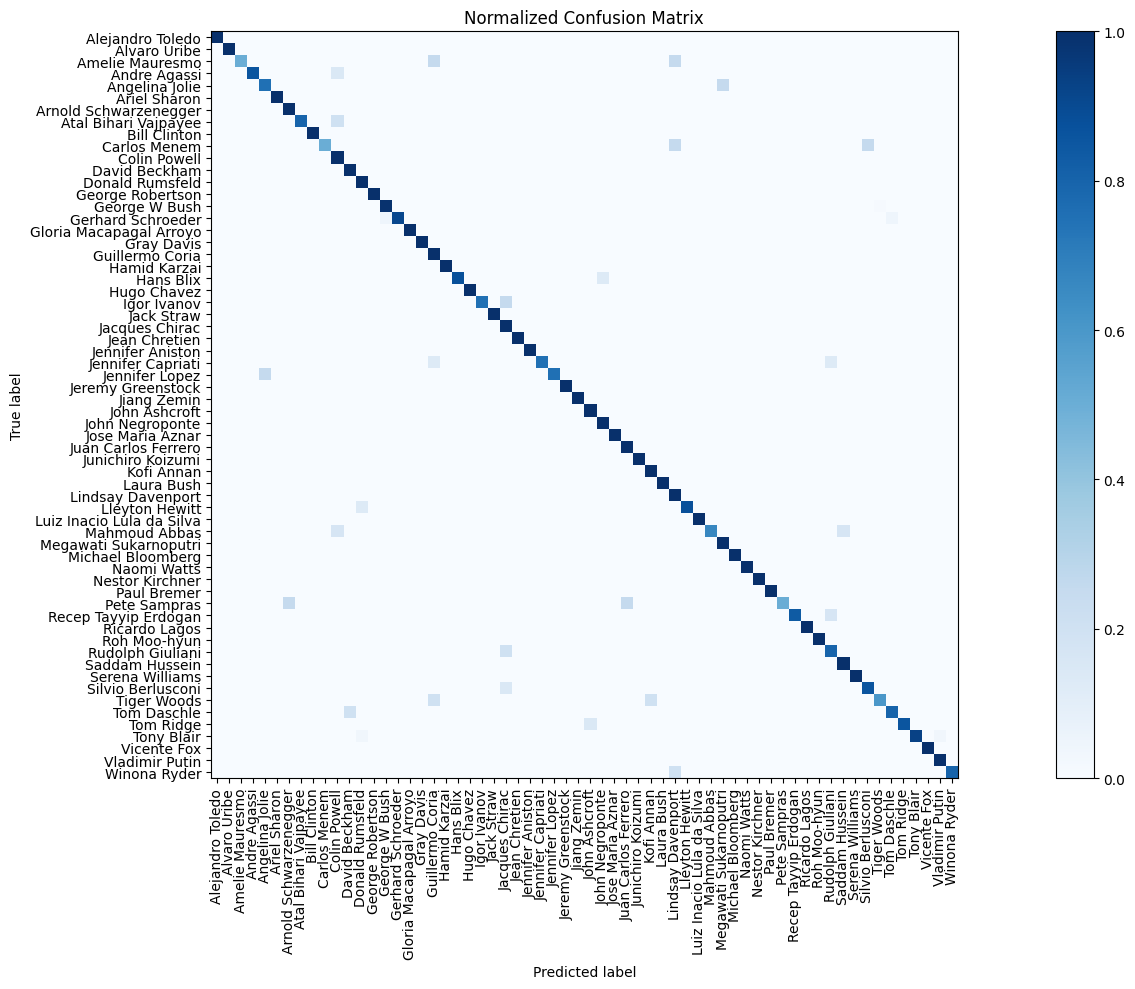

In [87]:
# Predict labels for the test dataset
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create a confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Visualize the confusion matrix
plt.figure(figsize=(20, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=90)
plt.yticks(tick_marks, target_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

**Assuming that all classes have the same importance, more appropriate measure would be the average accuracy among all classes.**

In [88]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict labels for the test dataset
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print classification report and confusion matrix
class_names = target_names.tolist()
print("Classification Report:")
print(classification_report(y_test.argmax(axis=1), y_pred_classes, target_names=class_names))

19/19 [==============================] - 1s 28ms/step - loss: 0.2032 - accuracy: 0.9504
Test Loss: 0.2032
Test Accuracy: 0.9504
19/19 [==============================] - 0s 21ms/step
Classification Report:
                           precision    recall  f1-score   support

         Alejandro Toledo       1.00      1.00      1.00         8
             Alvaro Uribe       1.00      1.00      1.00         7
          Amelie Mauresmo       1.00      0.50      0.67         4
             Andre Agassi       1.00      0.86      0.92         7
           Angelina Jolie       0.75      0.75      0.75         4
             Ariel Sharon       1.00      1.00      1.00        16
    Arnold Schwarzenegger       0.89      1.00      0.94         8
     Atal Bihari Vajpayee       1.00      0.80      0.89         5
             Bill Clinton       1.00      1.00      1.00         6
             Carlos Menem       1.00      0.50      0.67         4
             Colin Powell       0.94      1.00      0.97 

1/1 [==============================] - 0s 27ms/step


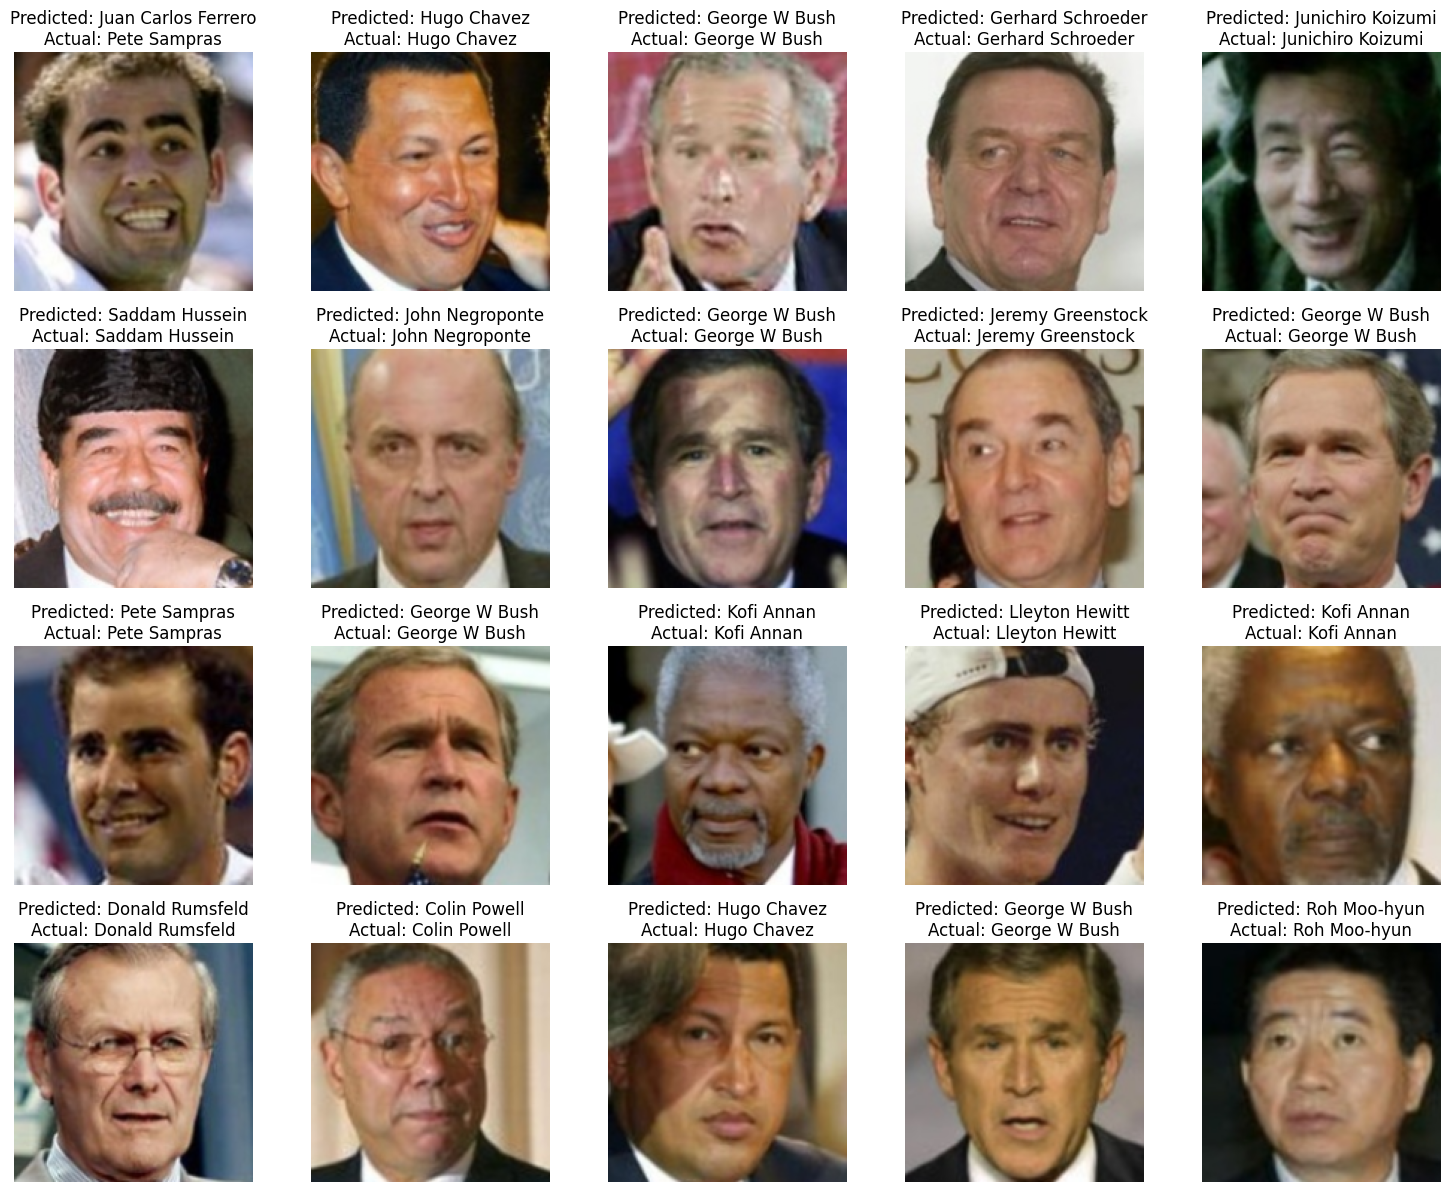

In [89]:
# Select 20 random test images for visualization
random_idxs = np.random.choice(len(X_test), size=20, replace=False)

plt.figure(figsize=(15, 15))
for i, idx in enumerate(random_idxs):
    # Load and preprocess the test image
    test_image = X_test[idx]
    test_image = np.expand_dims(test_image, axis=0)

    # Predict the class label for the test image
    predicted_class = model.predict(test_image)
    predicted_class_idx = np.argmax(predicted_class)
    predicted_label = target_names[predicted_class_idx]

    # Get the actual class label index
    actual_label_idx = y_test[idx]
    actual_label_idx = np.argmax(actual_label_idx)

    # Get the actual class label
    actual_label = target_names[actual_label_idx]

    # Display the test image and prediction
    plt.subplot(5, 5, i + 1)
    plt.imshow(test_image.squeeze(), cmap='gray')
    plt.title(f'Predicted: {predicted_label}\nActual: {actual_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()